### Install libraries
<font color='red'>**Make sure to restart the Colab runtime after installation**</font>

Colab Menu -> Runtime -> Restart runtime

In [1]:
!pip install open_clip_torch==2.23.0 transformers==4.35.2 matplotlib

## Load BiomedCLIP model

In [2]:
from open_clip import create_model_from_pretrained, get_tokenizer # works on open-clip-torch>=2.23.0, timm>=0.9.8

model, preprocess = create_model_from_pretrained('hf-hub:microsoft/BiomedCLIP-PubMedBERT_256-vit_base_patch16_224')
tokenizer = get_tokenizer('hf-hub:microsoft/BiomedCLIP-PubMedBERT_256-vit_base_patch16_224')

/home/shezhan/anaconda3/envs/biomedclip/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
open_clip_pytorch_model.bin: 100%|██████████| 784M/784M [00:14<00:00, 55.4MB/s] 


/home/shezhan/.cache/huggingface/hub/models--microsoft--BiomedCLIP-PubMedBERT_256-vit_base_patch16_224/snapshots/19a989005a398efdf80b5b44437c1a40c4a44fa9/open_clip_pytorch_model.bin


### Example: Zero-shot classifications

In [3]:
import torch
from urllib.request import urlopen
from PIL import Image

template = 'this is a photo of '
labels = [
    'adenocarcinoma histopathology',
    'brain MRI',
    'covid line chart',
    'squamous cell carcinoma histopathology',
    'immunohistochemistry histopathology',
    'bone X-ray',
    'chest X-ray',
    'pie chart',
    'hematoxylin and eosin histopathology'
]

dataset_url = 'https://huggingface.co/microsoft/BiomedCLIP-PubMedBERT_256-vit_base_patch16_224/resolve/main/example_data/biomed_image_classification_example_data/'
test_imgs = [
    'squamous_cell_carcinoma_histopathology.jpeg',
    'H_and_E_histopathology.jpg',
    'bone_X-ray.jpg',
    'adenocarcinoma_histopathology.jpg',
    'covid_line_chart.png',
    'IHC_histopathology.jpg',
    'chest_X-ray.jpg',
    'brain_MRI.jpg',
    'pie_chart.png'
]
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)
model.eval()

context_length = 256

images = torch.stack([preprocess(Image.open(urlopen(dataset_url + img))) for img in test_imgs]).to(device)
texts = tokenizer([template + l for l in labels], context_length=context_length).to(device)
with torch.no_grad():
    image_features, text_features, logit_scale = model(images, texts)

    logits = (logit_scale * image_features @ text_features.t()).detach().softmax(dim=-1)
    sorted_indices = torch.argsort(logits, dim=-1, descending=True)

    logits = logits.cpu().numpy()
    sorted_indices = sorted_indices.cpu().numpy()

top_k = -1

for i, img in enumerate(test_imgs):
    pred = labels[sorted_indices[i][0]]

    top_k = len(labels) if top_k == -1 else top_k
    print(img.split('/')[-1] + ':')
    for j in range(top_k):
        jth_index = sorted_indices[i][j]
        print(f'{labels[jth_index]}: {logits[i][jth_index]}')
    print('\n')

squamous_cell_carcinoma_histopathology.jpeg:
squamous cell carcinoma histopathology: 0.9974347949028015
adenocarcinoma histopathology: 0.0013077895855531096
hematoxylin and eosin histopathology: 0.001220701728016138
immunohistochemistry histopathology: 3.675646803458221e-05
chest X-ray: 1.1562086357774781e-11
brain MRI: 5.135226445462937e-12
pie chart: 2.5096693386655877e-12
covid line chart: 8.320963818149452e-13
bone X-ray: 2.3591251632868078e-14


H_and_E_histopathology.jpg:
hematoxylin and eosin histopathology: 0.9871525168418884
immunohistochemistry histopathology: 0.01263258047401905
adenocarcinoma histopathology: 0.00014957090024836361
squamous cell carcinoma histopathology: 5.232706826063804e-05
brain MRI: 1.0331223165849224e-05
chest X-ray: 1.7938563132702257e-06
bone X-ray: 6.823974558756163e-07
pie chart: 2.4570314849370334e-07
covid line chart: 4.083541144117575e-11


bone_X-ray.jpg:
bone X-ray: 0.9994791150093079
pie chart: 0.00044867504038847983
brain MRI: 4.2943622247548

<h2>Expected outputs</h2>
<details>
<pre>
adenocarcinoma_histopathology.jpg:
adenocarcinoma histopathology: 0.7818863987922668
hematoxylin and eosin histopathology: 0.15517690777778625
immunohistochemistry histopathology: 0.06149514392018318
squamous cell carcinoma histopathology: 0.0014182085869833827
chest X-ray: 2.017213228100445e-05
brain MRI: 1.2181524198240368e-06
pie chart: 7.932688959044754e-07
bone X-ray: 7.436410101036017e-07
covid line chart: 4.482610052036762e-07


covid_line_chart.png:
covid line chart: 0.9493210315704346
adenocarcinoma histopathology: 0.01898195780813694
squamous cell carcinoma histopathology: 0.0175501499325037
immunohistochemistry histopathology: 0.006791787222027779
hematoxylin and eosin histopathology: 0.003417333820834756
brain MRI: 0.002629919210448861
chest X-ray: 0.0010041205678135157
bone X-ray: 0.00024685842799954116
pie chart: 5.6812208640621975e-05


bone_X-ray.jpg:
bone X-ray: 0.9037961959838867
hematoxylin and eosin histopathology: 0.07279316335916519
brain MRI: 0.013534954749047756
chest X-ray: 0.00821212213486433
immunohistochemistry histopathology: 0.001647887285798788
squamous cell carcinoma histopathology: 1.418814281350933e-05
covid line chart: 1.1351590956110158e-06
adenocarcinoma histopathology: 2.3802124360372545e-07
pie chart: 9.433303205241828e-08


pie_chart.png:
pie chart: 0.999992847442627
covid line chart: 6.056906840967713e-06
brain MRI: 6.212158041307703e-07
bone X-ray: 1.870277799298492e-07
chest X-ray: 1.4315827456812258e-07
immunohistochemistry histopathology: 7.397970591682679e-08
hematoxylin and eosin histopathology: 1.3329795045535775e-08
adenocarcinoma histopathology: 7.695367898463701e-09
squamous cell carcinoma histopathology: 4.512833662317917e-09


H_and_E_histopathology.jpg:
hematoxylin and eosin histopathology: 0.7953251600265503
immunohistochemistry histopathology: 0.19779996573925018
chest X-ray: 0.005973907187581062
bone X-ray: 0.0008049230673350394
adenocarcinoma histopathology: 9.133991261478513e-05
squamous cell carcinoma histopathology: 3.6423973597266013e-06
brain MRI: 6.688684948130685e-07
pie chart: 4.278819574210502e-07
covid line chart: 3.051619401617245e-08


brain_MRI.jpg:
brain MRI: 0.9565795660018921
hematoxylin and eosin histopathology: 0.041418157517910004
immunohistochemistry histopathology: 0.0019450499676167965
pie chart: 2.7151252652402036e-05
squamous cell carcinoma histopathology: 1.0223812751064543e-05
bone X-ray: 8.662499567435589e-06
chest X-ray: 7.96773747424595e-06
adenocarcinoma histopathology: 2.7692055937222904e-06
covid line chart: 3.420084908611898e-07


chest_X-ray.jpg:
chest X-ray: 0.9998347759246826
hematoxylin and eosin histopathology: 0.0001205605294671841
bone X-ray: 4.112880560569465e-05
immunohistochemistry histopathology: 1.0486423889233265e-06
adenocarcinoma histopathology: 9.66637117016944e-07
covid line chart: 9.508977996119938e-07
brain MRI: 3.232386518448038e-07
squamous cell carcinoma histopathology: 2.53368597213921e-07
pie chart: 3.6984038054299617e-09


squamous_cell_carcinoma_histopathology.jpeg:
squamous cell carcinoma histopathology: 0.9469489455223083
adenocarcinoma histopathology: 0.05259034037590027
hematoxylin and eosin histopathology: 0.0003988408425357193
immunohistochemistry histopathology: 6.187965482240543e-05
chest X-ray: 1.4099594380923008e-08
pie chart: 3.522500624519864e-10
bone X-ray: 2.9633814846441453e-10
brain MRI: 1.2720452469139332e-10
covid line chart: 1.8425603924565603e-12


IHC_histopathology.jpg:
immunohistochemistry histopathology: 0.9465934634208679
hematoxylin and eosin histopathology: 0.03232448548078537
brain MRI: 0.020657211542129517
adenocarcinoma histopathology: 0.000304735847748816
bone X-ray: 4.5735167077509686e-05
squamous cell carcinoma histopathology: 3.150868360535242e-05
covid line chart: 2.0559578842949122e-05
chest X-ray: 1.2715442608168814e-05
pie chart: 9.55282575887395e-06
</pre>
</details>

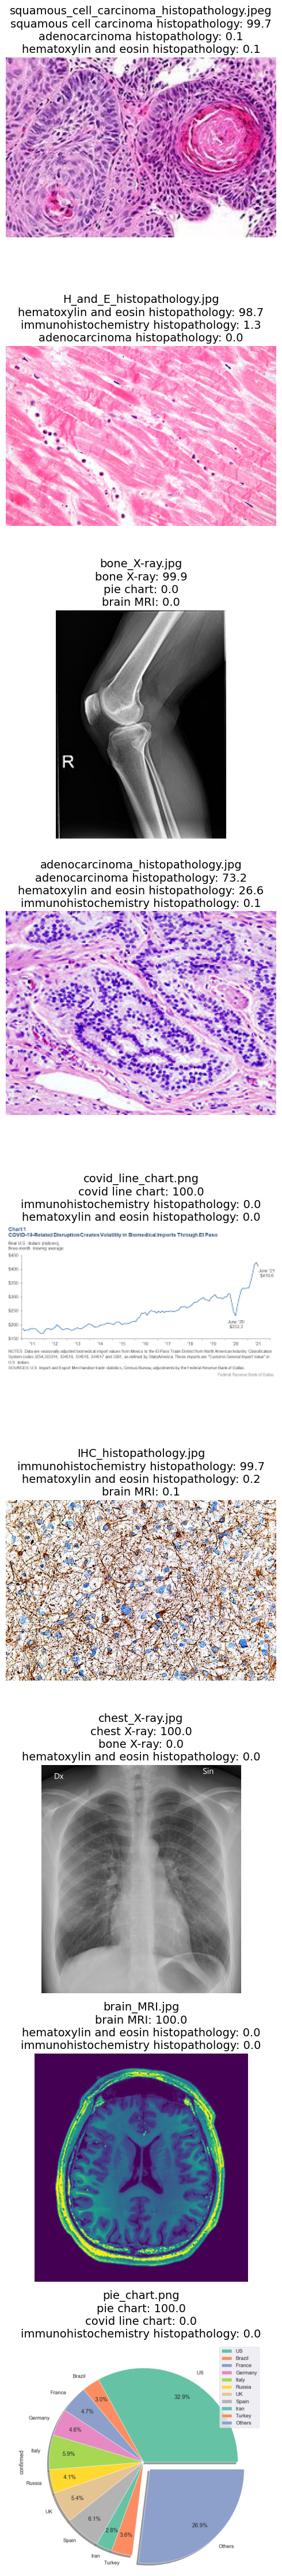

In [4]:
import matplotlib.pyplot as plt

def plot_images_with_metadata(images, metadata):
    num_images = len(images)
    fig, axes = plt.subplots(nrows=num_images, ncols=1, figsize=(5, 5 * num_images))

    for i, (img_path, metadata) in enumerate(zip(images, metadata)):
        img = Image.open(urlopen(dataset_url + img_path))
        ax = axes[i]
        ax.imshow(img)
        ax.axis('off')
        ax.set_title(f"{metadata['filename']}\n{metadata['top_probs']}", fontsize=14)

    plt.tight_layout()
    plt.show()

metadata_list = []

top_k = 3
for i, img in enumerate(test_imgs):
    pred = labels[sorted_indices[i][0]]
    img_name = img.split('/')[-1]

    top_probs = []
    top_k = len(labels) if top_k == -1 else top_k
    for j in range(top_k):
        jth_index = sorted_indices[i][j]
        top_probs.append(f"{labels[jth_index]}: {logits[i][jth_index] * 100:.1f}")

    metadata = {'filename': img_name, 'top_probs': '\n'.join(top_probs)}
    metadata_list.append(metadata)

plot_images_with_metadata(test_imgs, metadata_list)